In [779]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from os import listdir

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import main
from main import df_scrolling_object
import importlib
importlib.reload(main)

&lt;module &#39;main&#39; from &#39;c:\\Users\\Evgen\\skillfactory\\Projects\\Project_4\\main.py&#39;&gt;

In [780]:
input_folder = 'input/'
listdir(input_folder)

[&#39;train.csv&#39;]

| Столбец        |     Значение                    |
|:---------------|:--------------------------------|
|client_id	     |    идентификатор клиента        |  
|education	     |   уровень образования           | 
|sex	         | пол заёмщика  
|age             |	возраст заёмщика  
|car	         |флаг наличия автомобиля  
|car_type	     |флаг автомобиля-иномарки  
|decline_app_cnt |	количество отказанных прошлых заявок  
|good_work       |	флаг наличия «хорошей» работы  
|bki_request_cnt |	количество запросов в БКИ  
|home_address	 |категоризатор домашнего адреса  
|work_address	 |категоризатор рабочего адреса  
|income	         |доход заёмщика  
|foreign_passport|	наличие загранпаспорта  
|default	     |наличие дефолта  

In [781]:
data = pd.read_csv(input_folder + 'train.csv')
data.drop(['client_id'],  axis=1, inplace=True)

,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0
3,SCH,F,53,N,N,0,0,2,2,3,10000,N,0
4,GRD,M,48,N,N,0,1,1,2,3,30000,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,GRD,F,45,N,N,0,0,3,1,2,17000,N,0
73795,SCH,M,41,Y,Y,0,0,1,2,2,70000,N,0
73796,SCH,M,31,N,N,0,0,4,2,3,45000,N,0
73797,SCH,F,29,N,N,0,1,3,1,3,13000,N,1


In [782]:
bin_cols = ['good_work', 'foreign_passport', 'car', 'car_type', 'sex']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'home_address' , 'work_address']

In [784]:
# # edu_income_rel = data.groupby(by='education')['income'].agg(lambda x:x.mean()).sort_values()
# # print(edu_income_rel)
# # edu_income_rel = dict({'SCH': list([0, 31960.275039]),
# #                        'UGR': list([31960.275039,39391.796251]),
# #                        'GRD': list([39391.796251, 54663.948941]),
# #                        'PGR': list([54663.948941, 77548.206046]),
# #                        'ACD': list([77548.206046, 999999999999])})

# # def fill_edu(income, edu_income_rel):
# #     for edu, income_edu in edu_income_rel.items():
# #          if income_edu[0] < income <  income_edu[1]:
# #              return edu

# # na_index = data[data.education.isna()].index

# # data['education_isNAN'] = pd.isna(data.education).astype('uint8')

# for index in na_index:
#     inc = data.income.iloc[index]
#     data.education.iloc[index] = fill_edu(inc, edu_income_rel)
# # data.education.fillna(data.education.value_counts().index[0], inplace=True)

In [785]:
train = data

data1 = data.copy()
log_data = data1[num_cols].apply(np.log) 
train = log_data
# for i in num_cols:
#     plt.figure()
#     sns.distplot(train[i][train[i] > 0].dropna(), kde = False, rug=False)
#     plt.title(i)
#     plt.show()

In [786]:
# log_data['default'] = data['default']
# for col in num_cols:
#     my_func.get_boxplot(log_data, 'default', col)

&lt;AxesSubplot:&gt;

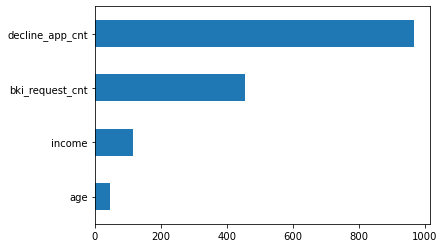

In [787]:
train = data
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [788]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(train['sex']))
print(dict(enumerate(label_encoder.classes_)))
# data['education'] = label_encoder.fit_transform(data['education'])

{0: &#39;F&#39;, 1: &#39;M&#39;}


In [789]:
label_encoder = LabelEncoder()


data_obj = df_scrolling_object()


,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,SCH,1,62,1,1,0,0,1,1,2,18000,0,0
1,SCH,0,59,0,0,0,0,3,2,3,19000,0,0
2,SCH,1,25,1,0,2,0,1,1,2,30000,1,0
3,SCH,0,53,0,0,0,0,2,2,3,10000,0,0
4,GRD,1,48,0,0,0,1,1,2,3,30000,1,0


In [791]:
# imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
#                                      discrete_features =True), index = bin_cols + cat_cols)
# imp_cat.sort_values(inplace = True)
# imp_cat.plot(kind = 'barh')

In [792]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)

In [793]:
X_cat.shape

(73799, 11)

In [794]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(train[num_cols].values)

In [795]:
# Объединяем
import main
from main import df_scrolling_object
import importlib
importlib.reload(main)

X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

data_obj = df_scrolling_object()
# X, Y = my_func.df_scrolling_object.return_XY()
X, Y = data_obj.return_XY()

In [796]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

&lt;matplotlib.legend.Legend at 0x1d79c8f3e48&gt;

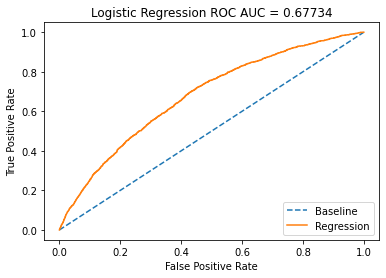

In [797]:
C = 1
penalty = 'l2'
model = LogisticRegression(C=C, penalty=penalty)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
# plt.show()
# feat_importances = pd.Series(logreg.feature_importances_, index=X.columns)
# feat_importances.nlargest(15).plot(kind='barh')

In [798]:
print()

In [799]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0


In [800]:
C

array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04])